In [1]:
import requests
import datetime
import time
import smtplib
import os
from mysql.connector import MySQLConnection, Error, connect 
import pandas as pd
import datetime
import matplotlib.pyplot as plt

dbuser = "dublinbikes"
dbpw = "dublin_bikes1"
dbname="dublinbikes"
dbhost = "dublinbikes.cigavyhinuih.eu-west-1.rds.amazonaws.com"

In [2]:
from sqlalchemy import create_engine

def connect_sql(user, pw, host, db):   
    connection = connect(user=user, password=pw, 
    host=host, database=db)  
    return connection  

def pull_occupancy_data(conn):
    qry = """SELECT stationnumber,status,bikestands,availablestands,
    availablebikes, updatetime FROM historicalstationdata"""
    cursor = conn.cursor()
    cursor.execute(qry) 
    
    stationnumbers = []
    statuses = []
    stands_total = []
    stands_available = []
    bikes_available = []
    updatetimes = []
    
    
    for (number, status, totalstands, standsavailable,bikesavailable, updatetime) in cursor:
        stationnumbers.append(number)
        statuses.append(status)
        stands_total.append(totalstands)
        stands_available.append(standsavailable) 
        bikes_available.append(bikesavailable) 
        updatetimes.append(updatetime)
    
    output_df = pd.DataFrame({"StationNumber":stationnumbers,
                             "Status":statuses,"TotalStands":stands_total,
                             "AvailableStands":stands_available,
                             "AvailableBikes":bikes_available,
                             "UpdateTime":updatetimes})

    cursor.close()
    conn.close()
    
    return output_df

def pull_weather_data(conn): 
    qry = """SELECT timestamp, temp, feelslike, wind, direction, weather, 
    detail, humidity, sunrise, sunset FROM weathercurrent"""
    
    cursor = conn.cursor()
    cursor.execute(qry) 
    
    timestamps = []
    temps = []
    feelslike = []
    winds = []
    directions = []
    weather = []
    details = []
    humidity = []
    sunrises = []
    sunsets = []
    
    
    for (ts, tmp, feels, wnd, dir_, wthr, deets, hum, sr, ss) in cursor:
        timestamps.append(ts)
        temps.append(tmp)
        feelslike.append(feels)
        winds.append(wnd)
        directions.append(dir_)
        weather.append(wthr) 
        details.append(deets) 
        humidity.append(hum)
        sunrises.append(sr) 
        sunsets.append(ss)
    
    output_df = pd.DataFrame({"UpdateTime":timestamps,
                             "Temp":temps,"FeelsLike":feelslike,
                             "Wind":winds,
                             "Direction":directions,
                             "Weather":weather,
                             "Details":details,
                             "Humidity":humidity,
                             "Sunrise":sunrises,
                             "Sunset":sunsets})

    cursor.close()
    conn.close()
    
    return output_df
    
    
    

In [3]:
conn = connect_sql(dbuser, dbpw, dbhost, dbname) 
occupancy_data = pull_occupancy_data(conn) 
conn = connect_sql(dbuser, dbpw, dbhost, dbname) 
weather_data = pull_weather_data(conn)



In [4]:
weather_data['UpdateTime'] = weather_data['UpdateTime'].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [5]:
occupancy_data = occupancy_data.sort_values(by="UpdateTime",ascending=True)
weather_data = weather_data.sort_values(by="UpdateTime",ascending=True)

In [6]:
occupancy_weather = pd.merge_asof(occupancy_data, weather_data, left_on="UpdateTime",right_on="UpdateTime", direction="backward",tolerance=datetime.timedelta(minutes=20))

In [7]:
occupancy_weather = occupancy_weather.dropna(how="any")

In [8]:
occupancy_weather['%BikesAvailable'] = occupancy_weather['AvailableBikes']/occupancy_weather['TotalStands']

In [9]:
occupancy_weather

,StationNumber,Status,TotalStands,AvailableStands,AvailableBikes,UpdateTime,Temp,FeelsLike,Wind,Direction,Weather,Details,Humidity,Sunrise,Sunset,%BikesAvailable
73744,78,OPEN,40,30,9,2021-02-18 21:18:54,5.44,-0.66,6.17,190.0,Clouds,scattered clouds,75.0,1.613634e+09,1.613670e+09,0.225000
73745,106,OPEN,40,30,10,2021-02-18 21:18:54,5.44,-0.66,6.17,190.0,Clouds,scattered clouds,75.0,1.613634e+09,1.613670e+09,0.250000
73746,11,OPEN,30,26,4,2021-02-18 21:18:54,5.44,-0.66,6.17,190.0,Clouds,scattered clouds,75.0,1.613634e+09,1.613670e+09,0.133333
73747,91,OPEN,30,16,14,2021-02-18 21:18:54,5.44,-0.66,6.17,190.0,Clouds,scattered clouds,75.0,1.613634e+09,1.613670e+09,0.466667
73748,51,OPEN,40,35,5,2021-02-18 21:18:54,5.44,-0.66,6.17,190.0,Clouds,scattered clouds,75.0,1.613634e+09,1.613670e+09,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442358,34,OPEN,30,17,13,2021-03-10 18:36:28,11.06,4.14,9.26,220.0,Clouds,broken clouds,82.0,1.615359e+09,1.615400e+09,0.433333
442359,102,OPEN,40,21,19,2021-03-10 18:36:28,11.06,4.14,9.26,220.0,Clouds,broken clouds,82.0,1.615359e+09,1.615400e+09,0.475000
442360,30,OPEN,20,6,14,2021-03-10 18:36:28,11.06,4.14,9.26,220.0,Clouds,broken clouds,82.0,1.615359e+09,1.615400e+09,0.700000
442361,24,OPEN,20,6,14,2021-03-10 18:36:37,11.06,4.14,9.26,220.0,Clouds,broken clouds,82.0,1.615359e+09,1.615400e+09,0.700000


In [10]:
occupancy_weather['DayOfWeek'] = occupancy_weather['UpdateTime'].apply(lambda x: x.weekday())
occupancy_weather['HourInDay'] = occupancy_weather['UpdateTime'].apply(lambda x: x.hour)

In [11]:
availability_by_hour_by_station = occupancy_weather[['StationNumber','HourInDay','%BikesAvailable']]

In [12]:
availability_by_hour_by_station['StationNumber'] = availability_by_hour_by_station['StationNumber'].apply(lambda x: "Station"+str(x))

<ipython-input-12-84c003e0c1cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  availability_by_hour_by_station['StationNumber'] = availability_by_hour_by_station['StationNumber'].apply(lambda x: "Station"+str(x))


In [13]:
availability_by_hour_by_station = availability_by_hour_by_station.groupby(by=['StationNumber','HourInDay']).mean()
availability_by_hour_by_station = availability_by_hour_by_station.reset_index()
availability_by_hour_by_station=availability_by_hour_by_station.pivot(index="HourInDay", columns="StationNumber",values="%BikesAvailable")
print(availability_by_hour_by_station)


StationNumber  Station10  Station100  Station101  Station102  Station103  \
HourInDay                                                                  
0               0.462776    0.747737    0.491484    0.318478    0.265876   
1               0.460938    0.740588    0.497549    0.318015    0.266296   
2               0.459239    0.741022    0.501460    0.318478    0.267391   
3               0.460018    0.742059    0.499755    0.318199    0.265257   
4               0.458942    0.741606    0.495272    0.315317    0.266423   
5               0.482328    0.743478    0.473148    0.318066    0.267279   
6               0.500000    0.748571    0.443192    0.315647    0.267086   
7               0.499144    0.743946    0.391216    0.305396    0.269964   
8               0.517857    0.618365    0.357176    0.285000    0.285461   
9               0.517411    0.557941    0.364925    0.298881    0.297080   
10              0.474743    0.527619    0.346756    0.279730    0.302289   
11          

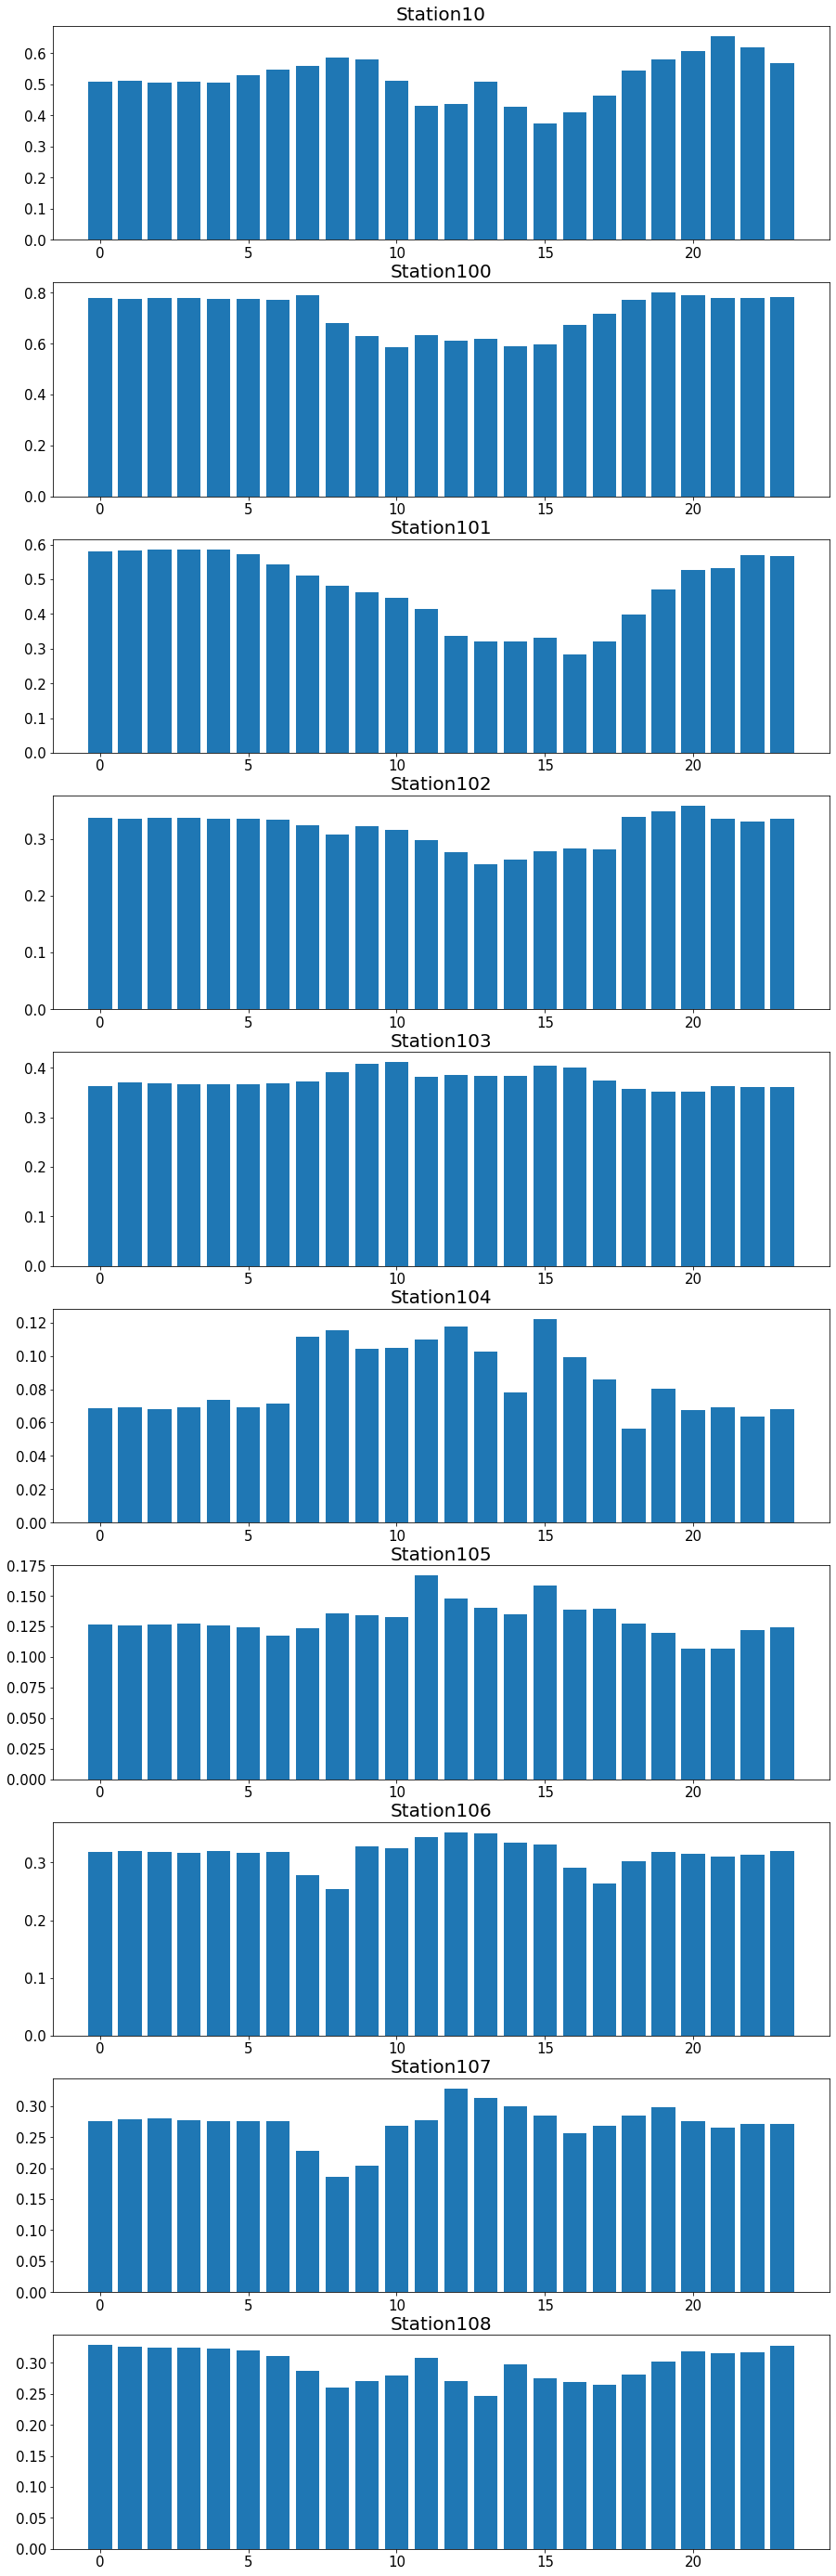

In [47]:
fig, axes = plt.subplots(len(availability_by_hour_by_station.columns[:10]))
fig.set_figheight(50)
fig.set_figwidth(15)
for i in range(len(availability_by_hour_by_station.columns[:10])): 
    station = availability_by_hour_by_station.columns[i]
    axes[i].bar(list(availability_by_hour_by_station.index), list(availability_by_hour_by_station[station]))
    axes[i].set_title(station, fontsize=20) 
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    


2